In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import re
from wordcloud import WordCloud

### Load the Dataset

In this section, we load the dataset containing Amazon gift card reviews. The dataset is in JSON format and includes various fields such as review text, ratings, and reviewer information. This data will be used for further analysis and sentiment evaluation.

In [4]:
# Load the dataset
url = 'https://raw.githubusercontent.com/Timothy965/COMP262_GROUP5/main/Dataset/Gift_Cards_5.json'
df = pd.read_json(url, lines=True)

# Function to check if a column is hashable
def is_hashable(s):
    return all(isinstance(x, (int, float, str, bool)) for x in s.dropna())

### Dateset Exploration
In this section, we explore the dataset to understand its structure and key characteristics. The following steps are performed:

1. **Basic Information**:
    - Total number of reviews
    - Average rating
    - Average review length
    - Dataframe info: Displays the structure and data types of the dataframe.

2. **Distribution of Reviews Across Products**:
    - We analyze the distribution of the number of reviews across different products using a histogram.

3. **Distribution of Reviews per User**:
    - We examine how many reviews each user has written and visualize this distribution.

4. **Review Lengths and Outliers**:
    - We analyze the lengths of the reviews and identify any outliers using a boxplot.

5. **Duplicate Reviews**:
    - We check for duplicate reviews using hashable columns and find that there are no duplicate reviews in the dataset.

Total number of reviews: 2972
Average rating: 4.885262449528937
Average review length: 67.46729602157788
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2972 entries, 0 to 2971
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         2972 non-null   int64  
 1   verified        2972 non-null   bool   
 2   reviewTime      2972 non-null   object 
 3   reviewerID      2972 non-null   object 
 4   asin            2972 non-null   object 
 5   style           864 non-null    object 
 6   reviewerName    2972 non-null   object 
 7   reviewText      2966 non-null   object 
 8   summary         2972 non-null   object 
 9   unixReviewTime  2972 non-null   int64  
 10  vote            208 non-null    float64
 11  image           12 non-null     object 
dtypes: bool(1), float64(1), int64(2), object(8)
memory usage: 258.4+ KB
Dataframe info
 None


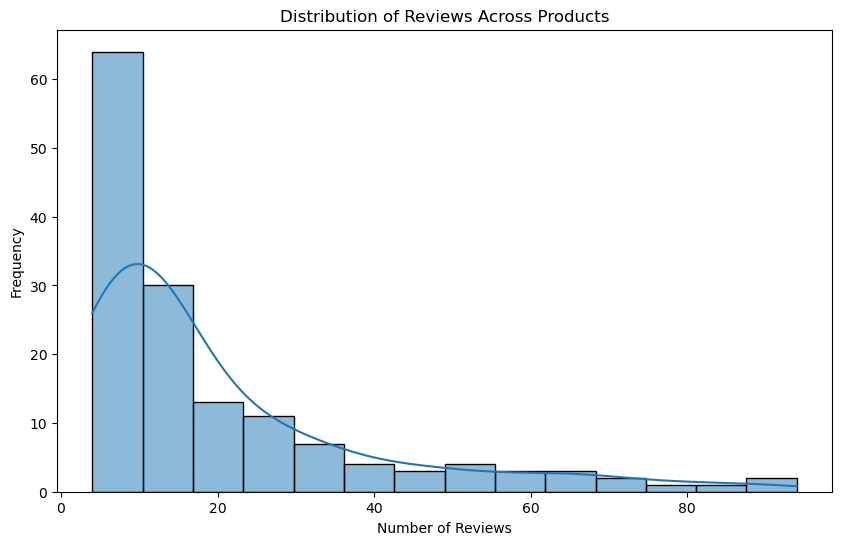

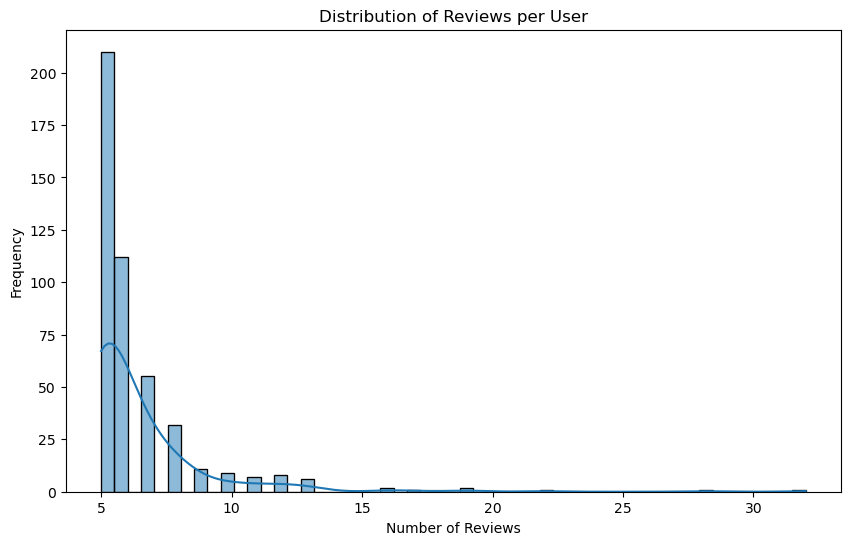

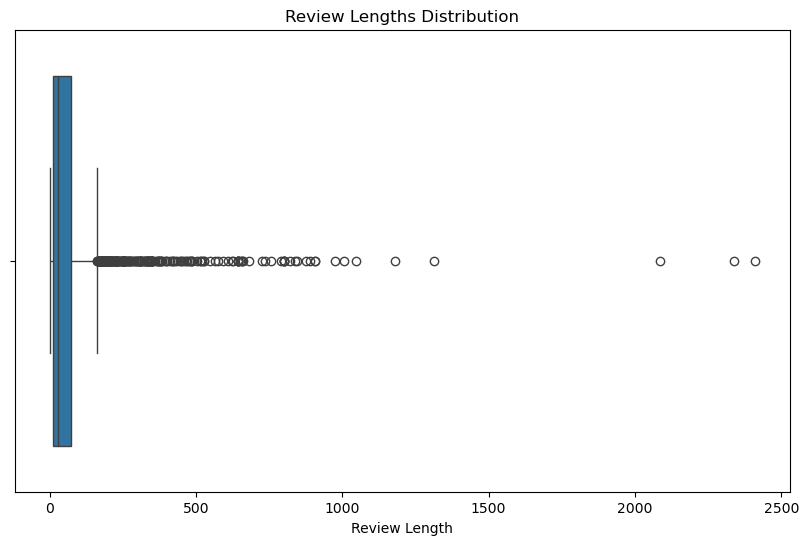

Minimum review length: 2.0
Maximum review length: 2409.0
Median review length: 29.0
Columns used for duplicate checking: ['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote']
Number of duplicate reviews (using hashable columns): 0


In [ ]:
# 1. Dataset data exploration
# a) Counts, averages, infor
print("Total number of reviews:", len(df))
print("Average rating:", df['overall'].mean())
print("Average review length:", df['reviewText'].str.len().mean())
print("Dataframe info\n", df.info())

# b) Distribution of the number of reviews across products
product_review_counts = df['asin'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(product_review_counts, kde=True)
plt.title('Distribution of Reviews Across Products')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()

# d) Distribution of reviews per user
user_review_counts = df['reviewerID'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(user_review_counts, kde=True)
plt.title('Distribution of Reviews per User')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()

# e) Review lengths and outliers
review_lengths = df['reviewText'].str.len()
plt.figure(figsize=(10, 6))
sns.boxplot(x=review_lengths)
plt.title('Review Lengths Distribution')
plt.xlabel('Review Length')
plt.show()

# f) Analyze lengths
print("Minimum review length:", review_lengths.min())
print("Maximum review length:", review_lengths.max())
print("Median review length:", review_lengths.median())

# g) Check for duplicates
# We'll check for duplicates using only hashable columns
hashable_columns = [col for col in df.columns if is_hashable(df[col])]
print("Columns used for duplicate checking:", hashable_columns)
duplicate_count = df.duplicated(subset=hashable_columns).sum()
print("Number of duplicate reviews (using hashable columns):", duplicate_count)

20 Most Frequent Words:
gift: 1679
card: 854
great: 720
love: 350
cards: 349
amazon: 292
good: 282
christmas: 188
like: 167
perfect: 159
worked: 158
nice: 155
use: 154
loved: 150
get: 134
always: 125
give: 122
easy: 110
time: 109
food: 109


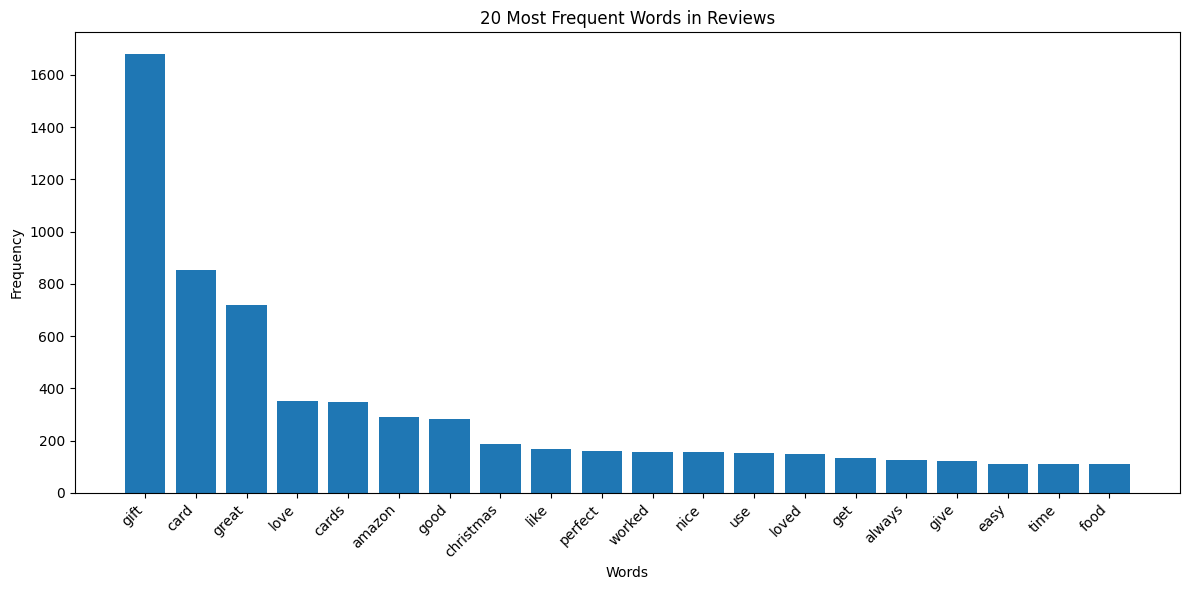

In [2]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and non-alphabetic tokens
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

# Combine all review texts
all_text = ' '.join(df['reviewText'].dropna())

# Preprocess the combined text
words = preprocess_text(all_text)

# Count word frequencies
word_freq = Counter(words)

# Get the 20 most common words
most_common_words = word_freq.most_common(20)

# Print the results
print("20 Most Frequent Words:")
for word, count in most_common_words:
    print(f"{word}: {count}")

# Visualize the results
words, counts = zip(*most_common_words)
plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.title('20 Most Frequent Words in Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

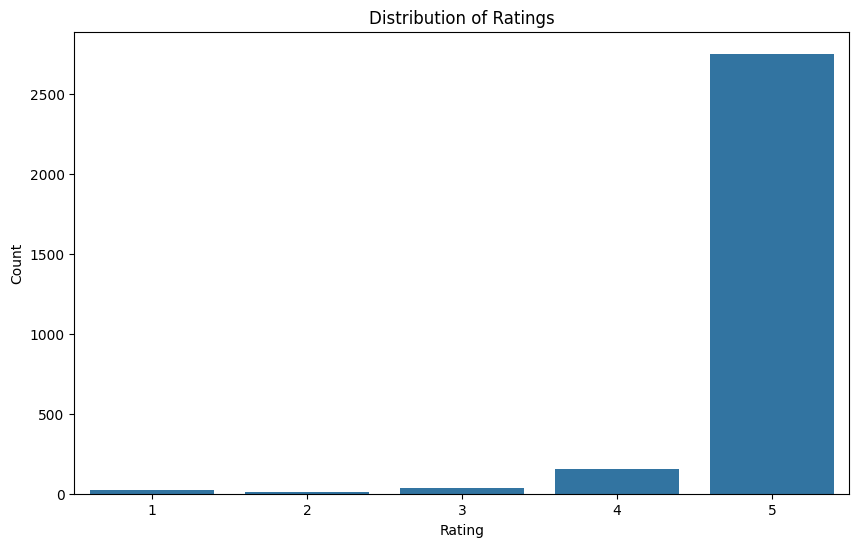

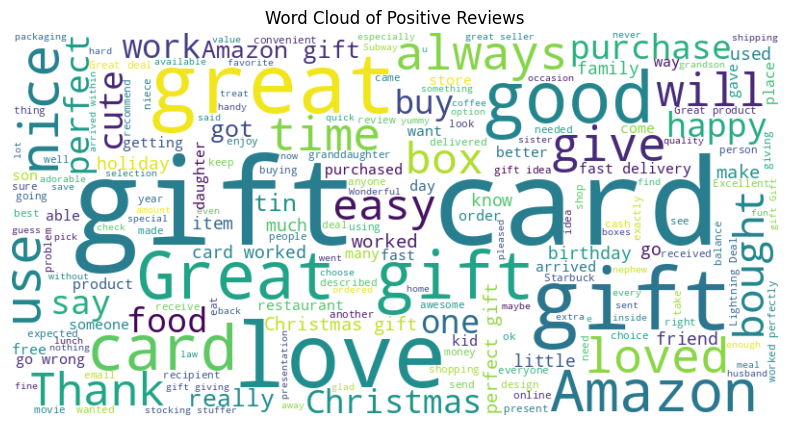

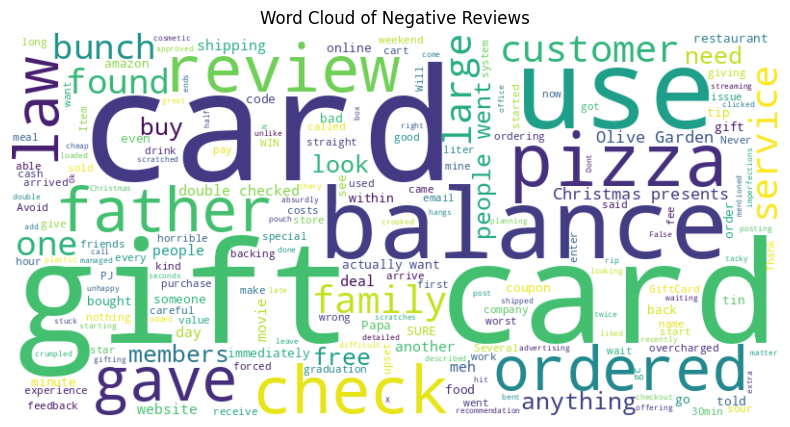

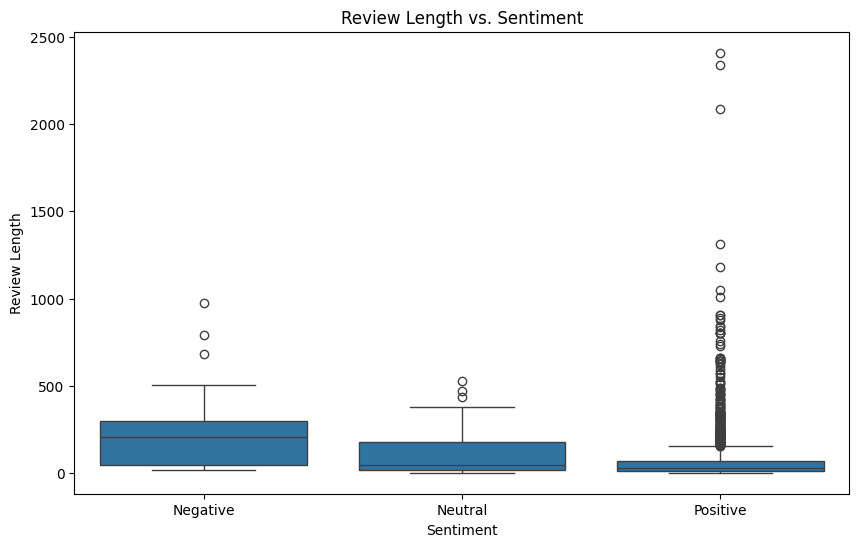


Average review length by sentiment:
sentiment
Negative    238.575758
Neutral     122.121212
Positive     64.898276
Name: review_length, dtype: float64


Correlation between review length and rating: -0.15


<ipython-input-8-7dfb7711225a>:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_length = df.groupby('sentiment')['review_length'].mean()


In [8]:
#  Rating distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='overall', data=df)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()
print()


#  Word clouds for positive and negative reviews
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Positive reviews (rating >= 4)
positive_reviews = ' '.join(df[df['overall'] >= 4]['reviewText'].dropna())
generate_wordcloud(positive_reviews, 'Word Cloud of Positive Reviews')
print()

# Negative reviews (rating <= 2)
negative_reviews = ' '.join(df[df['overall'] <= 2]['reviewText'].dropna())
generate_wordcloud(negative_reviews, 'Word Cloud of Negative Reviews')
print()

# Review length analysis
df['review_length'] = df['reviewText'].str.len()

# Create sentiment categories
df['sentiment'] = pd.cut(df['overall'],
                         bins=[-np.inf, 2, 3, np.inf],
                         labels=['Negative', 'Neutral', 'Positive'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='review_length', data=df)
plt.title('Review Length vs. Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Review Length')
plt.show()

# Calculate average review length for each sentiment
avg_length = df.groupby('sentiment')['review_length'].mean()
print("\nAverage review length by sentiment:")
print(avg_length)
print()

# Correlation between review length and rating
correlation = df['review_length'].corr(df['overall'])
print(f"\nCorrelation between review length and rating: {correlation:.2f}")


### Text Basic Pre-processing

In this section, we perform basic text pre-processing to prepare the review texts for sentiment analysis. The steps involved are:

1. **Label Data Based on Rating**:
    - Reviews are labeled as 'Positive', 'Neutral', or 'Negative' based on their rating.

2. **Select Appropriate Columns for Sentiment Analysis**:
    - We choose the columns `reviewText`, `summary`, and `sentiment` for sentiment analysis.

3. **Check for Outliers in Review Length**:
    - We calculate the Interquartile Range (IQR) and use it to identify outliers in the review lengths.

In [ ]:
# 2. Text basic pre-processing

# a) Label data based on rating
def label_sentiment(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['sentiment'] = df['overall'].apply(label_sentiment)

# b) Choose appropriate columns for sentiment analysis
selected_columns = ['reviewText', 'summary', 'sentiment']
sentiment_df = df[selected_columns]

# c) Check for outliers in review length
Q1 = review_lengths.quantile(0.25)
Q3 = review_lengths.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [ ]:
outliers = review_lengths[(review_lengths < lower_bound) | (review_lengths > upper_bound)]
print(f"Number of outliers in review length: {len(outliers)}")

Number of outliers in review length: 271


In [ ]:
# Display first few rows of the sentiment dataframe
print(sentiment_df.head())

                                         reviewText  \
0                               Another great gift.   
1                         Gift card for my daughter   
2                                      Nice present   
3  My niece loved this birthday greeting/gift card.   
4                                   fine as a gift.   

                          summary sentiment  
0                      Five Stars  Positive  
1                     Ease of use  Positive  
2                      Five Stars  Positive  
3  Love the convenience of eCards  Positive  
4                      Five Stars  Positive  


### Distribution of Sentiments

The distribution of sentiments in the dataset is visualized below:

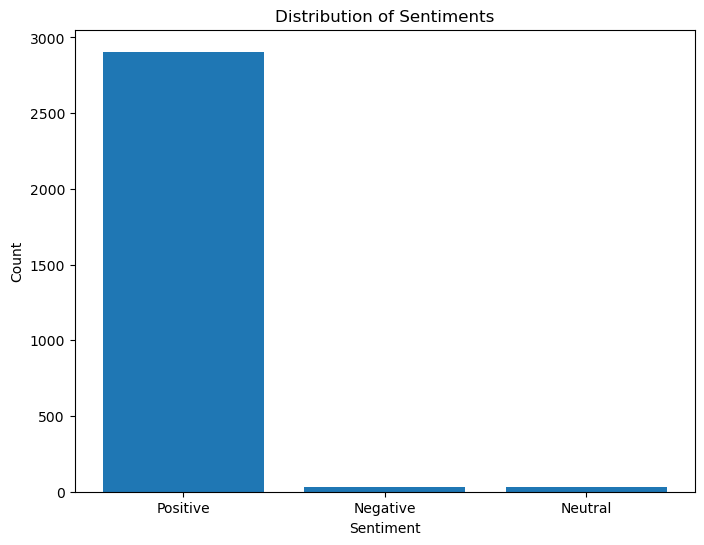

In [ ]:
# Distribution of sentiments
sentiment_counts = Counter(sentiment_df['sentiment'])
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.keys(), sentiment_counts.values())
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

### Download Necessary NLTK Data

To perform text preprocessing and sentiment analysis, we need to download the necessary NLTK data.


In [ ]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ShadowLobster\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ShadowLobster\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ShadowLobster\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ShadowLobster\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ShadowLobster\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Text Preprocessing

The `preprocess_text` function performs the following steps on the text data:
- Lowercasing
- Removing punctuation
- Tokenization
- Removing stop words
- Lemmatization

In [ ]:
# Pre-process the text
def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Removing punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenization
    words = word_tokenize(text)

    # Removing stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)


In [ ]:

sentiment_df = pd.DataFrame(sentiment_df)
sentiment_df.loc[:, 'reviewText'] = sentiment_df['reviewText'].astype(str).apply(preprocess_text)
sentiment_df.loc[:, 'summary'] = sentiment_df['summary'].astype(str).apply(preprocess_text)

### Selecting 1000 Reviews from the Dataset

To perform further analysis, we will randomly select 1000 reviews from the dataset.

In [ ]:
# Randomly select 1000 reviews from the dataset
sampled_reviews = sentiment_df.sample(n=1000, random_state=42)
print(sampled_reviews)

                                             reviewText  \
2400                           amazon gift card amazing   
2862                                         great deal   
2167                         great product great seller   
507                                 great gift tin cool   
2839  cute tag back add small little message person ...   
...                                                 ...   
2171                             nice gift presentation   
1251                                       nice product   
821   gave family member love coffee fact located ad...   
343                                               loved   
2726                              gift card always good   

                                                summary sentiment  
2400                                          five star  Positive  
2862                                          five star  Positive  
2167                                          five star  Positive  
507                

### Sentiment Analysis Using VADER and TextBlob

In this section, we will perform sentiment analysis on the preprocessed review texts using two different sentiment analysis tools: VADER and TextBlob.

1. **VADER Sentiment Analysis**:
    - VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.
    - We will use the `SentimentIntensityAnalyzer` from the `nltk.sentiment.vader` module to analyze the sentiment of the review texts.
    - The `vader_sentiment` function calculates the compound sentiment score for each review text.

2. **TextBlob Sentiment Analysis**:
    - TextBlob is a simple library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks.
    - We will use the `TextBlob` library to calculate the polarity of each review text.
    - The `textblob_sentiment` function calculates the polarity score for each review text.

The results of both sentiment analysis tools will be added as new columns to the `sentiment_df` dataframe. We will then display the first few rows of the dataframe with the new sentiment scores.

In [ ]:
# Initialize the sentiment analyzers
vader_analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment using VADER
def vader_sentiment(text):
    score = vader_analyzer.polarity_scores(text)
    return score['compound']

# Apply VADER sentiment analysis
sentiment_df['vader_sentiment'] = sentiment_df['reviewText'].apply(vader_sentiment)

# Function to get sentiment using TextBlob
def textblob_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply TextBlob sentiment analysis
sentiment_df['textblob_sentiment'] = sentiment_df['reviewText'].apply(textblob_sentiment)

# Display the first few rows of the dataframe with the new sentiment scores
print(sentiment_df.head())

                               reviewText                  summary sentiment  \
0                      another great gift                five star  Positive   
1                      gift card daughter                 ease use  Positive   
2                            nice present                five star  Positive   
3  niece loved birthday greetinggift card  love convenience ecards  Positive   
4                               fine gift                five star  Positive   

   vader_sentiment  textblob_sentiment  
0           0.7906            0.800000  
1           0.4404            0.000000  
2           0.4215            0.300000  
3           0.5994            0.700000  
4           0.5719            0.416667  


### Correlation Between VADER and TextBlob Sentiment Scores

In this section, we calculate the correlation between the sentiment scores obtained from VADER and TextBlob. The correlation value helps us understand the relationship between the two sentiment analysis tools.

We also create a comparison table that shows the average sentiment scores for each sentiment category (Positive, Neutral, Negative) as determined by both VADER and TextBlob.

In [ ]:
# Calculate the correlation between VADER and TextBlob sentiment scores
correlation = sentiment_df['vader_sentiment'].corr(sentiment_df['textblob_sentiment'])
print(f"Correlation between VADER and TextBlob sentiment scores: {correlation}")

# Create a comparison table
comparison_table = sentiment_df.groupby('sentiment').agg({
    'vader_sentiment': 'mean',
    'textblob_sentiment': 'mean'
}).reset_index()

print(comparison_table)

Correlation between VADER and TextBlob sentiment scores: 0.5057743871259345
  sentiment  vader_sentiment  textblob_sentiment
0  Negative         0.233642           -0.005633
1   Neutral         0.387991            0.177540
2  Positive         0.579573            0.432188


### Sentiment Analysis Evaluation

In this section, we evaluate the performance of VADER and TextBlob sentiment analysis tools by comparing their sentiment labels with the actual sentiment labels in the dataset. We use confusion matrices and classification reports to assess their accuracy.

- **Confusion Matrices**: Visualize the performance of the sentiment analysis tools by comparing the predicted labels with the true labels.
- **Classification Reports**: Provide detailed metrics such as precision, recall, and F1-score for each sentiment category (Positive, Neutral, Negative).


VADER Classification Report:
              precision    recall  f1-score   support

    Positive       0.98      0.88      0.93      2906
     Neutral       0.01      0.06      0.01        33
    Negative       0.20      0.36      0.26        33

    accuracy                           0.87      2972
   macro avg       0.40      0.44      0.40      2972
weighted avg       0.96      0.87      0.91      2972


TextBlob Classification Report:
              precision    recall  f1-score   support

    Positive       0.99      0.76      0.86      2906
     Neutral       0.01      0.27      0.03        33
    Negative       0.07      0.18      0.10        33

    accuracy                           0.75      2972
   macro avg       0.36      0.40      0.33      2972
weighted avg       0.97      0.75      0.84      2972

VADER Confusion Matrix:
[[2571  292   43]
 [  26    2    5]
 [  21    0   12]]

TextBlob Confusion Matrix:
[[2207  623   76]
 [  21    9    3]
 [  10   17    6]]


Text(627.9949494949494, 0.5, 'True Label')

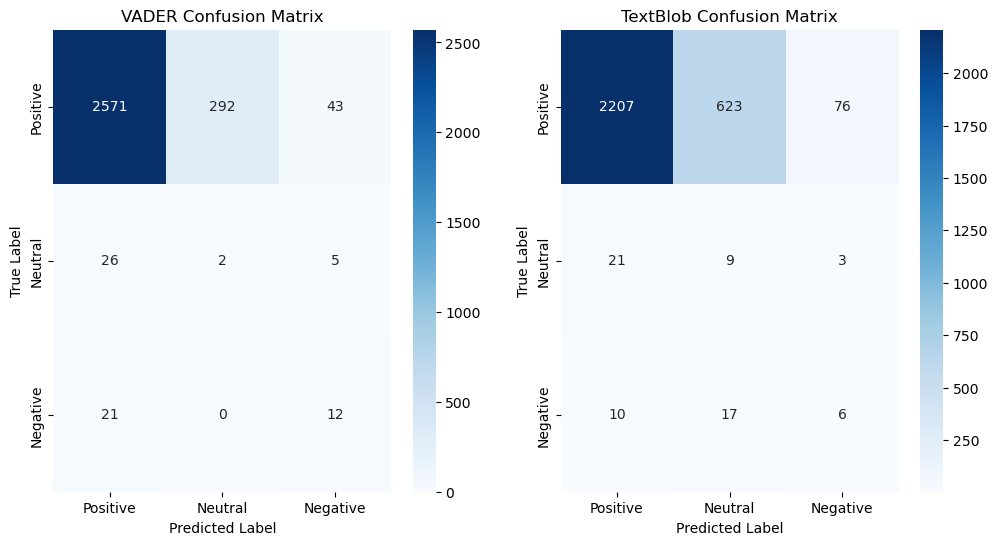

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Define a function to convert sentiment scores to labels
def score_to_label(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Convert VADER and TextBlob sentiment scores to labels
sentiment_df['vader_label'] = sentiment_df['vader_sentiment'].apply(score_to_label)
sentiment_df['textblob_label'] = sentiment_df['textblob_sentiment'].apply(score_to_label)

# Create confusion matrices
vader_cm = confusion_matrix(sentiment_df['sentiment'], sentiment_df['vader_label'], labels=['Positive', 'Neutral', 'Negative'])
textblob_cm = confusion_matrix(sentiment_df['sentiment'], sentiment_df['textblob_label'], labels=['Positive', 'Neutral', 'Negative'])

# Print classification reports
print("\nVADER Classification Report:")
print(classification_report(sentiment_df['sentiment'], sentiment_df['vader_label'], labels=['Positive', 'Neutral', 'Negative']))

print("\nTextBlob Classification Report:")
print(classification_report(sentiment_df['sentiment'], sentiment_df['textblob_label'], labels=['Positive', 'Neutral', 'Negative']))

# Print confusion matrices
print("VADER Confusion Matrix:")
print(vader_cm)
print("\nTextBlob Confusion Matrix:")
print(textblob_cm)

# Plot the confusion matrices
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(vader_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Neutral', 'Negative'], yticklabels=['Positive', 'Neutral', 'Negative'])
plt.title('VADER Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(1, 2, 2)
sns.heatmap(textblob_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Neutral', 'Negative'], yticklabels=['Positive', 'Neutral', 'Negative'])
plt.title('TextBlob Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')